In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
from env.LogitDemandPricingEnv import LogitDemandPricingEnv
np.random.seed(42)
import os
FIGURE_DIR = "./figure"
DATA_DIR = "./data/CIST"

In [4]:
def joint_to_index(i, j, grid_size):
    """Convert joint action (i,j) to index in Q-table."""
    return i * grid_size + j

class QLearningRuleAgent:
    """
    Q-learning agent for the duopoly-logit pricing game.
    Instead of using a Q-table to pick price index, this agent uses a Q-table to pick one of the following rules:
        - Rule 0: pick the price that matches the price index played by the other player in the previous round.
        - Rule 1: pick the price that is one index higher than the price index played by the other player in the previous round. (if the index is greater than n_actions-1, just pick n_actions-1)
        - Rule 2: pick the price that is one index lower than the price index played by the other player in the previous round. (if the index is less than or equal to 0, just pick 0)
        - Rule 3: Do nothing and keep the price index played in the previous round.
    Specific restriction: The RuleAgent can only pick one of the four rules, once picked, the agent will keep using the same rule for 4 rounds before next action change.
      - State s_t = price index played in previous round by the two players (i,j).
      - Action a_t ∈ {0,1,2,3} picks the next rule.
      - Greedy policy: always pick argmax_a Q[s, a].
    """
    def __init__(self, n_actions, alpha=0.1, gamma=0.9, cost=2.0, prices=None, rule_timer_thr=4):
        self.n_price_actions = n_actions      # e.g. 25 price levels
        self.n_rules = 4                      # exactly 4 rules
        self.alpha = alpha
        self.gamma = gamma
        self.omega = 1.5e-5
        self.t = 0                            # global time step for ε
        # Q-table: rows = joint‐state index, cols = rule‐index (0…3)
        self.Q = np.random.uniform(10, 20, size=(n_actions**2, self.n_rules))
        # bookkeeping for “stick with same rule for 4 periods”
        self.current_rule = 0
        self.rule_timer_thr = rule_timer_thr
        self.rule_timer = self.rule_timer_thr   # so we pick fresh immediately on t=0
        # track last price index
        self.last_price_idx = None

    def take_action(self, state, rival_pre_price_idx, own_pre_price_idx):
        # state encodes (own_pre, rival_pre); so we could also unpack it
        # but we pass in rival_pre and own_pre explicitly.
        if self.rule_timer >= self.rule_timer_thr:
        # if self.rule_timer >= 4:
            epsilon = np.exp(-self.t * self.omega)
            if np.random.rand() < epsilon:
                new_rule = np.random.randint(self.n_rules)
            else:
                new_rule = int(np.argmax(self.Q[state]))
            self.current_rule = new_rule
            self.rule_timer = 0
        price_idx = self._apply_rule(self.current_rule,
                                     rival_pre_price_idx,
                                     own_pre_price_idx)
        self.rule_timer += 1
        return price_idx

    def _apply_rule(self, rule, rival_idx, own_idx):
        if rule == 0:
            return rival_idx
        elif rule == 1:
            return min(rival_idx + 1, self.n_price_actions - 1)
        elif rule == 2:
            return max(rival_idx - 1, 0)
        elif rule == 3:
            # hold your own last price
            return own_idx

    def update(self, state, rule, reward, next_state):
        best_next = np.max(self.Q[next_state])
        td_target = reward + self.gamma * best_next
        self.Q[state, rule] += self.alpha * (td_target - self.Q[state, rule])
        self.t += 1
    

def simulate_batch(periods, runs, alpha, gamma, env, simfunc):
    """
    Run `runs` simulations in batch.

    Returns
    -------
    history1_all         : np.ndarray, shape (runs, periods)
        The time series of firm 1's chosen prices for each run.
    history_action_1_all : np.ndarray, shape (runs, periods)
        The time series of firm 1's actions for each run. Here is the rule index.
    history_profit_1_all : np.ndarray, shape (runs, periods)
        The time series of firm 1's profits for each run.
    """
    history1_all = []
    history_action_1_all = []
    history_profit_1_all = []

    for _ in range(runs):
        h1, ha1, hp1 = simfunc(env, periods, alpha, gamma)
        history1_all.append(h1)
        history_action_1_all.append(ha1)
        history_profit_1_all.append(hp1)

    return (
        np.array(history1_all),         # shape (runs, periods)
        np.array(history_action_1_all),
        np.array(history_profit_1_all)
    )

def move_average(x, window):
    """Compute moving average of x with window size."""
    return np.convolve(x, np.ones(window), 'valid') / window

def plot_percentiles(percentiles, periods, title, save_path=None, ne_price=None, mono_price=None):
    """
    Plot min, 25th, median, 75th, and max percentile lines.
    percentiles shape = (5, periods).
    Plot the monopoly price and Nash equilibrium price if provided as dashed lines.
    """
    window = 300
    x = np.arange(periods-window+1)
    labels_linestyle = [
        ('Min',           '-'),
        ('25th percentile','--'),
        ('Median',        '-'),
        ('75th percentile','--'),
        ('Max',           '-'),
    ]
    plt.figure(figsize=(10, 4))
    for idx, (label, ls) in enumerate(labels_linestyle):
        lw = 2 if label == 'Median' else 1
        # moving ave
        move_ave_pct = move_average(percentiles[idx], window=window)
        plt.plot(x, move_ave_pct, linestyle=ls, linewidth=lw, label=label)
    # plot monopoly price
    if ne_price is not None:
        plt.axhline(y=ne_price, color='grey', linestyle='--', label='Competitive Price (NE)')
    if mono_price is not None:
        plt.axhline(y=mono_price, color='grey', linestyle='--', label='Monopoly Price')
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_mean_with_se(history_array, periods, title, save_path=None, ne_price=None, mono_price=None):
    """
    Plot the mean with shaded standard error band from simulation histories.
    
    Parameters:
    - history_array : np.ndarray of shape (runs, periods)
    - periods       : int, total number of periods
    - title         : str, plot title
    - save_path     : str or None, file path to save the figure
    - ne_price      : float or None, optional line for NE price
    - mono_price    : float or None, optional line for monopoly price
    """
    window = 300
    runs = history_array.shape[0]

    mean_series = np.mean(history_array, axis=0)
    se_series = np.std(history_array, axis=0, ddof=1) / np.sqrt(runs)

    # moving averages
    mean_smooth = move_average(mean_series, window)
    se_smooth = move_average(se_series, window)

    x = np.arange(periods - window + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(x, mean_smooth, label='Mean Price', linewidth=2)
    plt.fill_between(x, mean_smooth - se_smooth, mean_smooth + se_smooth, alpha=0.3, label='±1 SE')
    
    if ne_price is not None:
        plt.axhline(y=ne_price, color='grey', linestyle='--', label='Competitive Price (NE)')
    if mono_price is not None:
        plt.axhline(y=mono_price, color='grey', linestyle='--', label='Monopoly Price')

    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def save_simulation_results(price_hist, action_hist, profit_hist, file_prefix, data_dir="DATA_DIR"):
    """
    Save simulation results of price, action, and profit histories to CSV files.

    Parameters:
    - price_hist (ndarray): Array of shape (runs, periods) for price history.
    - action_hist (ndarray): Array of shape (runs, periods) for action history.
    - profit_hist (ndarray): Array of shape (runs, periods) for profit history.
    - file_prefix (str): Prefix for output CSV filenames (e.g., 'q-learning-vs-q-learning-rule-price-competition').
    - data_dir (str): Directory where CSVs are saved.
    """

    run = price_hist.shape[0]

    df_price = pd.DataFrame(price_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])
    df_action = pd.DataFrame(action_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])
    df_profit = pd.DataFrame(profit_hist[:, -1000:].T, columns=[f"Run {i+1}" for i in range(run)])

    os.makedirs(data_dir, exist_ok=True)
    df_price.to_csv(os.path.join(data_dir, f"{file_prefix}-price.csv"), index=False)
    df_action.to_csv(os.path.join(data_dir, f"{file_prefix}-action.csv"), index=False)
    df_profit.to_csv(os.path.join(data_dir, f"{file_prefix}-profit.csv"), index=False)

    print(f"Simulation complete. Data saved to CSV files with prefix '{file_prefix}'.")

In [5]:
# --- 1) Define simulate_QrQr: two rule-based agents competing
def simulate_QrQr(env, periods, alpha=0.1, gamma=0.9):
    """
    Run a Q-learning-rule vs. Q-learning-rule price competition for `periods` steps.
    
    Returns
    -------
    history : np.ndarray, shape (periods,)
        The time series of firm 1's chosen prices.
    """
    n_actions = len(env.prices)
    # both agents now use the rule-agent
    agent0 = QLearningRuleAgent(n_actions, alpha=alpha, gamma=gamma, prices=env.prices, cost=env.cost, rule_timer_thr=2)
    agent1 = QLearningRuleAgent(n_actions, alpha=alpha, gamma=gamma, prices=env.prices, cost=env.cost, rule_timer_thr=2)
    
    history0 = np.zeros(periods)
    history1 = np.zeros(periods)

    history_action_0 = np.zeros(periods)
    history_action_1 = np.zeros(periods)

    history_profit_0 = np.zeros(periods)
    history_profit_1 = np.zeros(periods)

    (obs_0, obs_1), info = env.reset()
    state = joint_to_index(obs_0, obs_1, n_actions)

    for t in range(periods):
        # each rule-agent picks a price index
        a0 = agent0.take_action(state, rival_pre_price_idx=obs_1, own_pre_price_idx=obs_0)
        a1 = agent1.take_action(state, rival_pre_price_idx=obs_0, own_pre_price_idx=obs_1)

        # step the env
        (next_obs_0, next_obs_1), (r0, r1), term, trunc, info = env.step((a0, a1))
        next_state = joint_to_index(next_obs_0, next_obs_1, n_actions)

        # update both rule‐agents (pass their current_rule as the “action”)
        agent0.update(state, agent0.current_rule, r0, next_state)
        agent1.update(state, agent1.current_rule, r1, next_state)

        # record prices
        history0[t] = env.prices[a0]
        history1[t] = env.prices[a1]

        # record actions
        history_action_0[t] = agent0.current_rule
        history_action_1[t] = agent1.current_rule
        # record profits
        history_profit_0[t] = r0
        history_profit_1[t] = r1

        # roll forward
        obs_0, obs_1 = next_obs_0, next_obs_1
        state = next_state

        if term or trunc:
            break

    return history1, history_action_1, history_profit_1  # shape (periods,). Stores firm-1 price history, which is rule-based.

In [6]:
run=50 # later we only need 20 to get the percentiles.
periods = 200_000 # was 600_000
# periods = 1000
alpha = 0.15
gamma = 0.9
env = LogitDemandPricingEnv(
    price_min = 0.01,
    price_max = 10.0,
    grid_size = 25,
    marginal_cost = 2.0,
    beta = 0.95,
    a_0=0, # parameter for logit demand. OUtside option
    a_12=10, # parameter for logit demand. Inside option
    mu = 0.25 # parameter for logit demand. Vertical differentiation
)

# Calculate monopoly price and NE price
# Monopoly Price
func_mono_profit = lambda p: (p - env.cost) * (np.exp((env.a_12 - p) / env.mu) / (np.exp((env.a_12 - p) / env.mu) + np.exp((env.a_0) / env.mu)))
p_mono = minimize_scalar(lambda p: -func_mono_profit(p), bounds=(env.price_min, env.price_max), method='bounded').x
p_mono = np.round(p_mono, 2)
# Competitive Price
def func_nash_equilibrium(p_i, p_j):
    d_i = np.exp((env.a_12 - p_i) / env.mu) / (np.exp((env.a_12 - p_i) / env.mu) + np.exp((env.a_12 - p_j) / env.mu) + np.exp((env.a_0) / env.mu))
    d_j = np.exp((env.a_12 - p_j) / env.mu) / (np.exp((env.a_12 - p_i) / env.mu) + np.exp((env.a_12 - p_j) / env.mu) + np.exp((env.a_0) / env.mu))
    return (p_i - env.cost) * d_i, (p_j - env.cost) * d_j
def equations(p):
    p_i, p_j = p
    return func_nash_equilibrium(p_i, p_j)
p_nash = fsolve(equations, (env.price_min, env.price_min))[0]


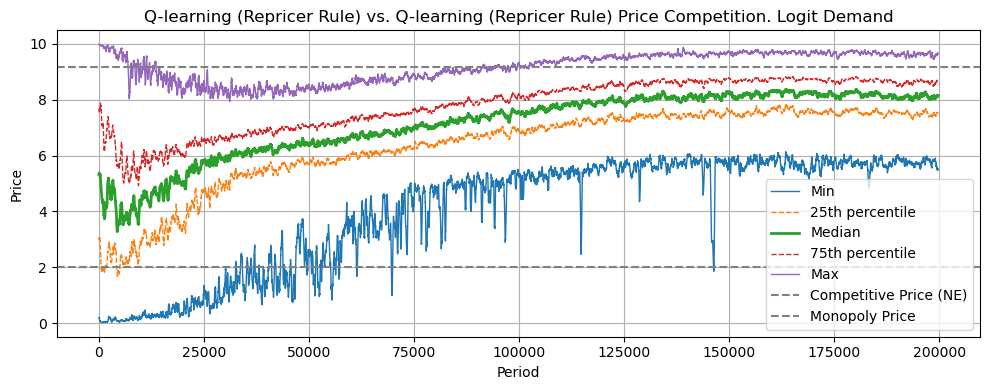

In [7]:
# --- 2) Batch-run Q-rule vs. Q-rule and plot percentiles

batch_qrqr = simulate_batch(
    periods=periods,
    runs=run,
    alpha=alpha,
    gamma=gamma,
    env=env,
    simfunc=simulate_QrQr
)
price_hist_qrqr, action_hist_qrqr, profit_hist_qrqr = batch_qrqr
# compute percentiles and plot
pc_qrqr = np.percentile(price_hist_qrqr, [0,25,50,75,100], axis=0)
plot_percentiles(
    percentiles=pc_qrqr,
    periods=periods,
    title="Q-learning (Repricer Rule) vs. Q-learning (Repricer Rule) Price Competition. Logit Demand",
    # save_path=os.path.join(FIGURE_DIR, "q-learning-rule-vs-q-learning-rule-price-competition.png"),
    ne_price=p_nash,
    mono_price=p_mono
)

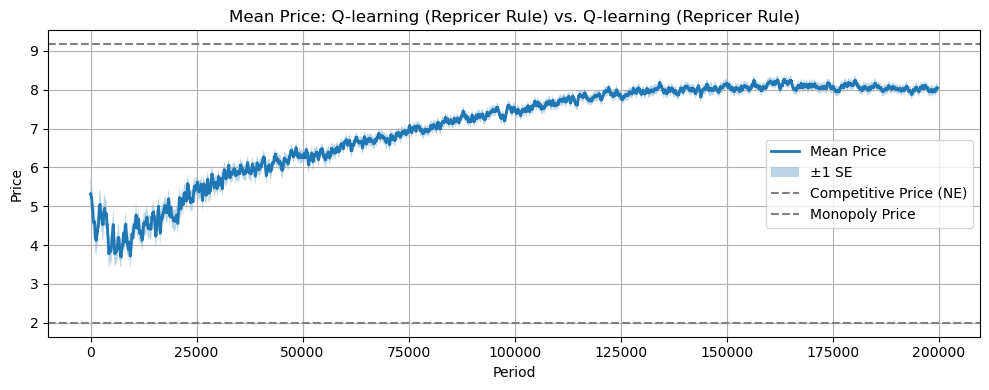

In [8]:
# Plot mean 
plot_mean_with_se(
    price_hist_qrqr,
    periods,
    title="Mean Price: Q-learning (Repricer Rule) vs. Q-learning (Repricer Rule)",
    ne_price=p_nash,
    mono_price=p_mono
)

In [ ]:
# Modified simulation result saving: every 100,000 periods, save a 1000-period slice
interval = 100_000
window = 1000
total_periods = periods
num_runs = price_hist_qrqr.shape[0]

# Save the first 2000 periods explicitly
for start in [0, 1000]:
    end = start + window
    df_price = pd.DataFrame(price_hist_qrqr[:, start:end].T, columns=[f"Run {i+1}" for i in range(num_runs)])
    df_action = pd.DataFrame(action_hist_qrqr[:, start:end].T, columns=[f"Run {i+1}" for i in range(num_runs)])
    df_profit = pd.DataFrame(profit_hist_qrqr[:, start:end].T, columns=[f"Run {i+1}" for i in range(num_runs)])
    
    file_prefix = f"q-learning-rule-vs-q-learning-rule-price-competition-p{start:06d}"
    os.makedirs(DATA_DIR, exist_ok=True)
    df_price.to_csv(os.path.join(DATA_DIR, f"{file_prefix}-price.csv"), index=False)
    df_action.to_csv(os.path.join(DATA_DIR, f"{file_prefix}-action.csv"), index=False)
    df_profit.to_csv(os.path.join(DATA_DIR, f"{file_prefix}-profit.csv"), index=False)

# Continue saving every 100,000 periods after the first 2000
for t in range(100_000, total_periods, interval):
    if t + window <= total_periods:
        df_price = pd.DataFrame(price_hist_qrqr[:, t:t+window].T, columns=[f"Run {i+1}" for i in range(num_runs)])
        df_action = pd.DataFrame(action_hist_qrqr[:, t:t+window].T, columns=[f"Run {i+1}" for i in range(num_runs)])
        df_profit = pd.DataFrame(profit_hist_qrqr[:, t:t+window].T, columns=[f"Run {i+1}" for i in range(num_runs)])

        file_prefix = f"q-learning-rule-vs-q-learning-rule-price-competition-p{t:06d}"
        df_price.to_csv(os.path.join(DATA_DIR, f"{file_prefix}-price.csv"), index=False)
        df_action.to_csv(os.path.join(DATA_DIR, f"{file_prefix}-action.csv"), index=False)
        df_profit.to_csv(os.path.join(DATA_DIR, f"{file_prefix}-profit.csv"), index=False)

print(f"Simulation complete. All snapshots saved in directory '{DATA_DIR}'.")

Simulation complete. All snapshots saved in directory './data/CIST'.
